In [93]:

"""
This cell imports necessary libraries and modules for image classification and segmentation tasks.

Imports:
- ss_fusion_seg from model: Custom segmentation model.
- torch, nn: PyTorch library for deep learning.
- numpy as np: Numerical operations.
- matplotlib.pyplot as plt: Plotting library.
- confusion_matrix, accuracy_score, classification_report, cohen_kappa_score from sklearn.metrics: Evaluation metrics.
- split_data, utils, create_graph from model: Custom utility functions.
- metrics, preprocessing from sklearn: Machine learning utilities.
- build_optim_wrapper from mmengine.optim: Optimizer wrapper.
- custom_layer_decay_optimizer_constructor, layer_decay_optimizer_constructor_vit from mmcv_custom: Custom optimizer constructors.
- random: Random number generation.
- os: Operating system interfaces.
- torch.utils.data as Data: Data utilities for PyTorch.
- copy: Shallow and deep copy operations.
- scipy.io as sio: I/O operations for MATLAB files.
- spectral as spy: Hyperspectral image processing.
- Counter from collections: Counter for counting hashable objects.
- PCA from sklearn.decomposition: Principal Component Analysis.
"""
from model import ss_fusion_seg
import torch
from torch  import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,cohen_kappa_score
from model import split_data,utils,create_graph
from sklearn import metrics, preprocessing
from mmengine.optim import build_optim_wrapper
from mmcv_custom import custom_layer_decay_optimizer_constructor,layer_decay_optimizer_constructor_vit
import random
import os
import torch.utils.data as Data
import copy
import scipy.io as sio
import spectral as spy
from collections import Counter
from sklearn.decomposition import PCA

In [94]:

"""
Determine the device to be used for computation.

This cell sets the device to GPU if available, otherwise defaults to CPU.
"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [95]:

class DataReader():
    """
    This cell defines the DataReader class, which is responsible for reading and normalizing data cubes and ground truth values.
    Classes:
        DataReader: A class to handle data cube and ground truth operations.
    Methods:
        __init__(self): Initializes the DataReader with data_cube and g_truth set to None.
        cube: Property that returns the original data cube.
        truth: Property that returns the ground truth data.
        normal_cube: Property that returns the normalized data cube with values ranging from 0 to 1.
    """
    def __init__(self):
        self.data_cube = None
        self.g_truth = None

    @property
    def cube(self):
        """
        origin data
        """
        return self.data_cube

    @property
    def truth(self):
        return self.g_truth

    @property
    def normal_cube(self):
        """
        normalization data: range(0, 1)
        """
        return (self.data_cube - np.min(self.data_cube)) / (np.max(self.data_cube) - np.min(self.data_cube))

class IndianRaw(DataReader):
    def __init__(self):
        super(IndianRaw, self).__init__()
        raw_data_package = sio.loadmat(r"data/Indian_pines_corrected.mat")
        self.data_cube = raw_data_package["data"].astype(np.float32)
        truth = sio.loadmat(r"data/Indian_pines_gt.mat")
        self.g_truth = truth["groundT"].astype(np.float32)

In [96]:
def load_data():
    """
    Loads the Indian Pines hyperspectral dataset.

    Returns:
        tuple: A tuple containing:
            - data (numpy.ndarray): The hyperspectral data cube.
            - data_gt (numpy.ndarray): The ground truth labels.
    """
    data = IndianRaw().cube
    data_gt =IndianRaw().truth
    return data, data_gt

In [97]:
"""
Configuration and data loading for image classification using HyperSIGMA.
Variables:
    patch_size (int): Size of the image patches.
    img_size (int): Size of the images.
    pca_components (int): Number of PCA components.
    split_type (str): Type of data split ('number' or 'ratio').
    train_num (int): Number of training samples.
    val_num (int): Number of validation samples.
    train_ratio (float): Ratio of training data.
    val_ratio (float): Ratio of validation data.
    max_epoch (int): Maximum number of training epochs.
    batch_size (int): Size of the training batch.
    dataset_name (str): Name of the dataset.
    path_weight (str): Path to save the model weights.
    path_result (str): Path to save the results.
    data (ndarray): Loaded image data.
    data_gt (ndarray): Ground truth labels for the data.
    height_orgin (int): Original height of the data.
    width_orgin (int): Original width of the data.
    bands (int): Number of spectral bands in the data.
    class_num (int): Number of classes in the ground truth data.
"""
patch_size =8
img_size = 128
pca_components = 20
split_type = ['number', 'ratio'][0]
train_num = 10
val_num =0
train_ratio = 0.999  
val_ratio = 0.001 
max_epoch = 300
batch_size = 64 
dataset_name = 'HH'

path_weight = r"weights//"
path_result = r"result//"
data, data_gt = load_data()
data_unprocessed = copy.deepcopy(data)
data_gt_unprocessed = copy.deepcopy(data_gt)
height_orgin, width_orgin, bands = data.shape
class_num = np.max(data_gt)
class_num = class_num.astype(int)

In [98]:
"""
Applies PCA to the given data and splits it.

Variables:
    data (DataFrame): The input data to be processed.
    pca (PCA): The PCA object after applying PCA transformation.
    pca_components (int): The number of principal components to keep.

Functions:
    split_data.apply_PCA: Function to apply PCA on the data.
"""
data, pca = split_data.apply_PCA(data, num_components=pca_components)
data_processed = copy.deepcopy(data)

In [99]:
"""
Reshape the ground truth data and split it into training, validation, and test indices.

Steps:
1. Reshape the ground truth data (`data_gt`) into a 1D array.
2. Split the reshaped data into training, validation, and test indices using the `split_data` function.

Variables:
- data_gt: Ground truth data to be reshaped and split.
- class_num: Number of classes in the dataset.
- train_ratio: Ratio of the dataset to be used for training.
- train_num: Number of training samples.
- val_num: Number of validation samples.
- split_type: Method used for splitting the data.

Returns:
- train_index: Indices for the training data.
- val_index: Indices for the validation data.
- test_index: Indices for the test data.
"""
gt_reshape = np.reshape(data_gt, [-1])
train_index, val_index, test_index = split_data.split_data(gt_reshape, class_num, train_ratio, train_ratio, train_num, val_num, split_type)

In [100]:
"""
This code snippet performs the following operations:
1. Converts the `train_index`, `val_index`, and `test_index` arrays to integer type.
2. Reshapes the `data_gt` array into a 1D array `gt_reshape`.
3. Finds the maximum value in `gt_reshape` and assigns it to `class_num`.
4. Converts `class_num` to an integer type.

Variables:
- train_index (array-like): The training indices.
- val_index (array-like): The validation indices.
- test_index (array-like): The test indices.
- data_gt (array-like): The ground truth data.
- gt_reshape (array-like): The reshaped ground truth data.
- class_num (int): The number of classes, derived from the maximum value in `gt_reshape`.
"""
train_index=train_index.astype(int)
val_index=val_index.astype(int)
test_index=test_index.astype(int)
gt_reshape = np.reshape(data_gt, [-1])
class_num = np.max(gt_reshape)
class_num = class_num.astype(int)

In [101]:
"""
This cell retrieves ground truth labels and label masks for training, testing, and validation datasets.

Functions:
- create_graph.get_label: Extracts ground truth labels for the specified indices.
- create_graph.get_label_mask: Generates label masks for the datasets based on the ground truth labels.

Variables:
- train_samples_gt: Ground truth labels for the training dataset.
- test_samples_gt: Ground truth labels for the testing dataset.
- val_samples_gt: Ground truth labels for the validation dataset.
- train_label_mask: Label mask for the training dataset.
- test_label_mask: Label mask for the testing dataset.
- val_label_mask: Label mask for the validation dataset.
"""
train_samples_gt, test_samples_gt, val_samples_gt = create_graph.get_label(gt_reshape, train_index, val_index, test_index)

train_label_mask, test_label_mask, val_label_mask = create_graph.get_label_mask(train_samples_gt, test_samples_gt, val_samples_gt, data_gt, class_num)

In [102]:
"""
Reshape ground truth samples and convert them to one-hot encoded format.
This script performs the following steps:
1. Reshapes the ground truth samples for training, testing, and validation datasets.
2. Converts the reshaped ground truth samples to one-hot encoded format.
Variables:
    train_samples_gt (numpy.ndarray): Ground truth samples for training.
    test_samples_gt (numpy.ndarray): Ground truth samples for testing.
    val_samples_gt (numpy.ndarray): Ground truth samples for validation.
    height_orgin (int): Original height of the samples.
    width_orgin (int): Original width of the samples.
    class_num (int): Number of classes for one-hot encoding.
Functions:
    create_graph.label_to_one_hot(array, num_classes): Converts a label array to one-hot encoded format.
Outputs:
    train_gt_onehot (numpy.ndarray): One-hot encoded ground truth for training.
    test_gt_onehot (numpy.ndarray): One-hot encoded ground truth for testing.
    val_gt_onehot (numpy.ndarray): One-hot encoded ground truth for validation.
"""
train_gt = np.reshape(train_samples_gt,[height_orgin,width_orgin])
test_gt = np.reshape(test_samples_gt,[height_orgin,width_orgin])
val_gt = np.reshape(val_samples_gt,[height_orgin,width_orgin])


train_gt_onehot = create_graph.label_to_one_hot(train_gt, class_num)
test_gt_onehot = create_graph.label_to_one_hot(test_gt, class_num)
val_gt_onehot = create_graph.label_to_one_hot(val_gt, class_num)


In [103]:
"""
Converts numpy arrays to PyTorch tensors and moves them to the specified device.

Variables:
    train_samples_gt (numpy.ndarray): Ground truth training samples.
    test_samples_gt (numpy.ndarray): Ground truth test samples.
    val_samples_gt (numpy.ndarray): Ground truth validation samples.
    train_gt_onehot (numpy.ndarray): One-hot encoded ground truth training labels.
    test_gt_onehot (numpy.ndarray): One-hot encoded ground truth test labels.
    val_gt_onehot (numpy.ndarray): One-hot encoded ground truth validation labels.
    train_label_mask (numpy.ndarray): Mask for training labels.
    test_label_mask (numpy.ndarray): Mask for test labels.
    val_label_mask (numpy.ndarray): Mask for validation labels.
    device (torch.device): The device to which the tensors will be moved.

Converts:
    All numpy arrays are converted to PyTorch tensors of type float32 and moved to the specified device.
"""
train_samples_gt=torch.from_numpy(train_samples_gt.astype(np.float32)).to(device)
test_samples_gt=torch.from_numpy(test_samples_gt.astype(np.float32)).to(device)
val_samples_gt=torch.from_numpy(val_samples_gt.astype(np.float32)).to(device)
train_gt_onehot = torch.from_numpy(train_gt_onehot.astype(np.float32)).to(device)
test_gt_onehot = torch.from_numpy(test_gt_onehot.astype(np.float32)).to(device)
val_gt_onehot = torch.from_numpy(val_gt_onehot.astype(np.float32)).to(device)

train_label_mask = torch.from_numpy(train_label_mask.astype(np.float32)).to(device)
test_label_mask = torch.from_numpy(test_label_mask.astype(np.float32)).to(device)
val_label_mask = torch.from_numpy(val_label_mask.astype(np.float32)).to(device)

In [104]:
"""
This script performs the following operations:
1. Loads and preprocesses training and testing data using the `utils.Get_train_and_test_data` function.
2. Converts the training images to PyTorch tensors and reshapes them.
3. Creates a PyTorch `TensorDataset` from the training images.
4. Initializes DataLoader objects for training, validation, and testing datasets.

Functions:
- utils.Get_train_and_test_data(img_size, data, data_gt): 
    Loads and preprocesses the training and testing data.

Variables:
- img_train: 
    A tensor containing the training images.
- num_H: 
    The height of the images.
- num_W: 
    The width of the images.
- data_gt: 
    Ground truth data.
- data: 
    The dataset containing the images.
- height: 
    The height of the dataset.
- width: 
    The width of the dataset.
- bands: 
    The number of bands in the dataset.
- data_train: 
    A PyTorch `TensorDataset` containing the training images.
- train_loader: 
    A DataLoader for the training dataset.
- val_loader: 
    A DataLoader for the validation dataset.
- test_loader: 
    A DataLoader for the testing dataset.
"""
img_train, num_H, num_W,data_gt,data = utils.Get_train_and_test_data(img_size, data,data_gt)
height, width, bands = data.shape 
img_train = torch.from_numpy(img_train.transpose(0,3,1,2)).type(torch.FloatTensor) 
data_train = Data.TensorDataset(img_train)
train_loader = Data.DataLoader(data_train, batch_size=num_H,shuffle=False)
val_loader = Data.DataLoader(data_train, batch_size=num_H,shuffle=False)
test_loader = Data.DataLoader(data_train, batch_size=num_H,shuffle=False)

padding img: (256, 256, 20)


In [105]:
"""
Adjusts the ground truth labels for the training samples by decrementing each label by 1.

This operation is performed in-place on the `train_samples_gt` array for the indices specified in `train_index`.

Args:
    train_samples_gt (numpy.ndarray): Array containing the ground truth labels for the training samples.
    train_index (numpy.ndarray or list): Indices of the training samples whose labels need to be adjusted.

Returns:
    None
"""
train_samples_gt[train_index] = train_samples_gt[train_index] -1

In [106]:
"""
Initializes a tensor of zeros and creates an instance of the SSFusionFramework model.

Variables:
    zeros (torch.Tensor): A tensor of zeros with shape [height_orgin * width_orgin], moved to the specified device and converted to float.

Model Initialization:
    model (SSFusionFramework): An instance of the SSFusionFramework model with the following parameters:
        img_size (int): The size of the input image.
        in_channels (int): The number of PCA components.
        patch_size (int): The size of the patches.
        classes (int): The number of classes for classification.
        model_size (str): The size of the model, with optional values 'base', 'large', and 'huge'.
"""
zeros = torch.zeros([height_orgin * width_orgin]).to(device).float()
model = ss_fusion_seg.SSFusionFramework(
                img_size = img_size,
                in_channels = pca_components,
                patch_size=patch_size,
                classes = class_num,
                # model_size='base'#The optional values are 'base','large' and 'huge'
                model_size='huge'#The optional values are 'base','large' and 'huge'
)


In [107]:
"""
This script performs the following operations:

1. Loads spatial network weights from a file and removes specific keys related to 'patch_embed.proj', 'spat_map', 'spat_output_maps', and 'pos_embed'.
2. Renames the remaining keys by adding a 'spat_encoder.' prefix and stores them in a dictionary.
3. Loads spectral network weights from a file and removes specific keys related to 'patch_embed.proj', 'spat_map', and 'fpn1.0.weight'.
4. Renames the remaining keys by adding a 'spec_encoder.' prefix and stores them in a dictionary.
5. Merges the spatial and spectral weights dictionaries.
6. Updates the model's state dictionary with the merged weights, ensuring only keys that exist in the model's state dictionary are updated.
7. Loads the updated state dictionary into the model.

Variables:
- model_params: State dictionary of the model.
- spat_net: Loaded spatial network weights.
- spat_weights: Dictionary of spatial network weights with updated keys.
- per_net: Loaded spectral network weights.
- spec_weights: Dictionary of spectral network weights with updated keys.
- merged_params: Merged dictionary of spatial and spectral network weights.
- same_parsms: Dictionary of weights that exist in both the merged weights and the model's state dictionary.
"""
model_params =model.state_dict()
# spat_net = torch.load((r"../spat-base.pth"), map_location=torch.device('cpu'))
spat_net = torch.load((r"../spat-huge.pth"), map_location=torch.device('cpu'))
for k in list(spat_net['model'].keys()):
    if 'patch_embed.proj' in k:
        del spat_net['model'][k]
for k in list(spat_net['model'].keys()):
    if 'spat_map' in k:
        del spat_net['model'][k]
for k in list(spat_net['model'].keys()):
    if 'spat_output_maps' in k:
        del spat_net['model'][k]
for k in list(spat_net['model'].keys()):
    if 'pos_embed' in k:
        del spat_net['model'][k]
spat_weights = {}
prefix = 'spat_encoder.'
for key, value in spat_net['model'].items():
    new_key = prefix + key
    spat_weights[new_key] = value
# per_net = torch.load((r"../spec-base.pth"), map_location=torch.device('cpu'))
per_net = torch.load((r"../spec-huge.pth"), map_location=torch.device('cpu'))
model_params =model.state_dict()
for k in list(per_net['model'].keys()):
    if 'patch_embed.proj' in k:
        del per_net['model'][k]
    if 'spat_map' in k:
        del per_net['model'][k]
    if 'fpn1.0.weight' in k:
        del per_net['model'][k]
spec_weights = {}
prefix = 'spec_encoder.'
for key, value in per_net['model'].items():
    new_key = prefix + key
    spec_weights[new_key] = value
model_params =model.state_dict()
for k in list(spec_weights.keys()):
    if 'spec_encoder.patch_embed' in k:
        del spec_weights[k]
merged_params = {**spat_weights, **spec_weights}
same_parsms = {k: v for k, v in merged_params.items() if k in model_params.keys()}
model_params.update(same_parsms)
model.load_state_dict(model_params)

<All keys matched successfully>

In [108]:
"""
This script sets up the optimizer, learning rate scheduler, and loss criterion for training a model.

Attributes:
    optim_wrapper (dict): Configuration dictionary for the optimizer and its parameters.
        optimizer (dict): Specifies the type of optimizer (AdamW) and its hyperparameters.
            type (str): Type of optimizer.
            lr (float): Learning rate.
            betas (tuple): Coefficients used for computing running averages of gradient and its square.
            weight_decay (float): Weight decay (L2 penalty).
        constructor (str): Name of the constructor for the optimizer.
        paramwise_cfg (dict): Configuration for parameter-wise settings.
            num_layers (int): Number of layers in the model.
            layer_decay_rate (float): Decay rate for the learning rate across layers.
    optimizer (Optimizer): The optimizer built using the provided configuration.
    scheduler (CosineAnnealingLR): Learning rate scheduler that adjusts the learning rate using a cosine annealing schedule.
    criterion (CrossEntropyLoss): Loss function used for training.
    model (nn.Module): The model to be trained.
    device (torch.device): The device on which the model is to be trained.
    count (int): Counter for tracking iterations or epochs.
    best_loss (float): Variable to track the best validation loss achieved during training.
    train_losses (list): List to store training losses for each epoch.
    val_losses (list): List to store validation losses for each epoch.
"""
optim_wrapper = dict(
    optimizer=dict(
    type='AdamW', lr=6e-5, betas=(0.9, 0.999), weight_decay=0.05),
    constructor='LayerDecayOptimizerConstructor_ViT', 
    paramwise_cfg=dict(
        num_layers=12, 
        layer_decay_rate=0.9,
    )
)
optimizer = build_optim_wrapper(model, optim_wrapper)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer.optimizer, max_epoch, eta_min=0, last_epoch=-1)
criterion = nn.CrossEntropyLoss()
model.to(device)
count = 0
best_loss = 99999
train_losses = []
val_losses = []

{'num_layers': 12, 'layer_decay_rate': 0.9}
Build LayerDecayOptimizerConstructor 0.900000 - 14
Param groups = {
  "layer_13_no_decay": {
    "param_names": [
      "spat_encoder.pos_embed",
      "spat_encoder.classifier.0.bias",
      "spat_encoder.classifier.1.bias",
      "spat_encoder.classifier.2.bias",
      "spat_encoder.patch_embed.proj.bias",
      "spat_encoder.blocks.0.norm1.weight",
      "spat_encoder.blocks.0.norm1.bias",
      "spat_encoder.blocks.0.attn.qkv.bias",
      "spat_encoder.blocks.0.attn.sampling_offsets.bias",
      "spat_encoder.blocks.0.attn.proj.bias",
      "spat_encoder.blocks.0.norm2.weight",
      "spat_encoder.blocks.0.norm2.bias",
      "spat_encoder.blocks.0.mlp.fc1.bias",
      "spat_encoder.blocks.0.mlp.fc2.bias",
      "spat_encoder.blocks.1.norm1.weight",
      "spat_encoder.blocks.1.norm1.bias",
      "spat_encoder.blocks.1.attn.qkv.bias",
      "spat_encoder.blocks.1.attn.sampling_offsets.bias",
      "spat_encoder.blocks.1.attn.proj.bias",
  

In [109]:
max_epoch

300

In [110]:
"""
Trains a neural network model for image classification over a specified number of epochs.

Args:
    max_epoch (int): The maximum number of epochs for training.
    num_W (int): The width of the prediction tensor.
    num_H (int): The height of the prediction tensor.
    class_num (int): The number of classes for classification.
    img_size (int): The size of the input images.
    train_loader (DataLoader): DataLoader for the training dataset.
    model (torch.nn.Module): The neural network model to be trained.
    device (torch.device): The device to run the model on (e.g., 'cpu' or 'cuda').
    criterion (torch.nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
    train_index (torch.Tensor): Indices for training samples.
    train_samples_gt (torch.Tensor): Ground truth labels for training samples.
    train_gt_onehot (torch.Tensor): One-hot encoded ground truth labels for training samples.
    zeros (torch.Tensor): Tensor of zeros for evaluation.
    height (int): Height of the reshaped image.
    width (int): Width of the reshaped image.
    height_orgin (int): Original height of the image.
    width_orgin (int): Original width of the image.
    path_weight (str): Path to save the model weights.

Returns:
    None

Notes:
    - The model is saved if the current loss is less than the best loss encountered so far.
    - Training performance is evaluated and printed every 10 epochs.
"""

for epoch in range(max_epoch + 1):
    pred = torch.zeros([num_W, num_H, class_num, img_size, img_size])
    optimizer.zero_grad() 
    for batch_idx, (batch_data) in enumerate(train_loader):
        for i in range(num_H):
            netinput = batch_data[0][i]
            netinput = torch.unsqueeze(netinput, 0).to(device)
            batch_pred = model(netinput)
            batch_pred = batch_pred.reshape(img_size, img_size, -1)
            batch_pred = batch_pred.permute([2, 0, 1])
            pred[batch_idx, i] = batch_pred
    pred = torch.reshape(pred, [num_H, num_W, class_num, img_size, img_size])
    pred = torch.permute(pred, [2, 0, 3, 1, 4])
    pred = torch.reshape(pred, [class_num, num_H * img_size * num_W * img_size])
    pred = torch.permute(pred, [1, 0])     
    y = pred.to(device)
    train_index = train_index.reshape(-1,)
    y_orgin = utils.image_reshape(y, height, width, height_orgin, width_orgin, class_num)
    loss = criterion(y_orgin[train_index], train_samples_gt[train_index].long())
    loss.backward(retain_graph=False)
    optimizer.step()
    if epoch % 10 == 0:
        trainOA = utils.evaluate_performance(y_orgin, train_samples_gt, train_gt_onehot, zeros)
        print("{}\ttrain loss={:.4f}\t train OA={:.4f} ".format(str(epoch + 1), loss, trainOA))
        if loss < best_loss:
            best_loss = loss
            print('save model')
            torch.save(model.state_dict(), path_weight + r"model.pt")


c:\Users\Bjornolo\anaconda3\envs\AI\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


1	train loss=7.0423	 train OA=0.0667 
save model
11	train loss=5.8249	 train OA=0.4867 
save model
21	train loss=1.4117	 train OA=0.7933 
save model
31	train loss=0.2203	 train OA=0.9467 
save model
41	train loss=0.0847	 train OA=0.9800 
save model
51	train loss=0.0281	 train OA=1.0000 
save model
61	train loss=0.0145	 train OA=1.0000 
save model
71	train loss=0.0115	 train OA=1.0000 
save model
81	train loss=0.0084	 train OA=1.0000 
save model
91	train loss=0.0087	 train OA=1.0000 
101	train loss=0.0067	 train OA=1.0000 
save model
111	train loss=0.0051	 train OA=1.0000 
save model
121	train loss=0.0049	 train OA=1.0000 
save model
131	train loss=0.0049	 train OA=1.0000 
save model
141	train loss=0.0034	 train OA=1.0000 
save model
151	train loss=0.0033	 train OA=1.0000 
save model
161	train loss=0.0032	 train OA=1.0000 
save model
171	train loss=0.0030	 train OA=1.0000 
save model
181	train loss=0.0022	 train OA=1.0000 
save model
191	train loss=0.0029	 train OA=1.0000 
201	train los

In [111]:
"""
Performs inference on a pre-trained model and evaluates its performance on a test dataset.

Steps:
1. Clears the CUDA cache.
2. Loads the model weights from a specified path.
3. Sets the model to evaluation mode.
4. Initializes a tensor to store predictions.
5. Iterates over the test data loader and performs inference for each batch.
6. Reshapes and permutes the prediction tensor to match the desired output format.
7. Evaluates the performance of the model using various metrics.

Args:
    path_weight (str): Path to the directory containing the model weights.
    num_W (int): Number of width segments.
    num_H (int): Number of height segments.
    class_num (int): Number of classes.
    img_size (int): Size of the image.
    test_loader (DataLoader): DataLoader for the test dataset.
    device (torch.device): Device to perform computations on (CPU or GPU).
    height (int): Height of the reshaped image.
    width (int): Width of the reshaped image.
    height_orgin (int): Original height of the image.
    width_orgin (int): Original width of the image.
    test_samples_gt (Tensor): Ground truth samples for the test dataset.
    test_gt_onehot (Tensor): One-hot encoded ground truth for the test dataset.
    test_gt (Tensor): Ground truth labels for the test dataset.

Returns:
    None

Prints:
    Overall accuracy (OA) of the model on the test dataset.
    Kappa coefficient.
    Accuracy for each class.
    Average accuracy across all classes.
"""
torch.cuda.empty_cache()
with torch.no_grad():
    model.load_state_dict(torch.load(path_weight + r"model.pt"))
    model.eval()
    pred = torch.zeros([num_W, num_H, class_num, img_size, img_size])
    for batch_idx, (batch_data) in enumerate(test_loader):
        for w in range(num_H):
            netinput = batch_data[0][w]
            netinput = torch.unsqueeze(netinput, 0).to(device)
            batch_pred = model(netinput)
            #batch_pred = batch_pred.detach()
            batch_pred = batch_pred.reshape(img_size,img_size,-1)
            batch_pred =batch_pred. permute(([2, 0, 1]), 0)
            pred[batch_idx,w] = batch_pred
    pred = torch.reshape(pred, [num_H, num_W, class_num, img_size, img_size])
    pred = torch.permute(pred, [2, 0, 3, 1, 4])  # [2,num_H, img_size,num_W, img_size]]
    pred = torch.reshape(pred, [class_num, num_H * img_size* num_W * img_size])
    pred = torch.permute(pred, [1, 0])     
    y =pred.to(device)
    y_orgin = utils.image_reshape(y,height,width,height_orgin,width_orgin,class_num)
    overall_acc,OA_hi1,average_acc,kappa,each_acc=utils.evaluate_performance_all(y_orgin, test_samples_gt, test_gt_onehot,  height_orgin, width_orgin, class_num, test_gt,device, require_AA_KPP=True, printFlag=False)
    print("test OA={:.4f}".format(overall_acc))
    print('kappa=',kappa)
    print('each_acc=',each_acc)
    print('average_acc=',average_acc)

c:\Users\Bjornolo\anaconda3\envs\AI\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


test OA=0.8169
kappa= [0.793553646232539]
each_acc= [array([1.        , 0.72849083, 0.82439024, 1.        , 0.77378436,
       0.94583333, 1.        , 0.93589744, 1.        , 0.93762994,
       0.6997955 , 0.68267581, 0.98461538, 0.89721116, 0.92819149,
       0.95180723])]
average_acc= [0.8931451695091148]


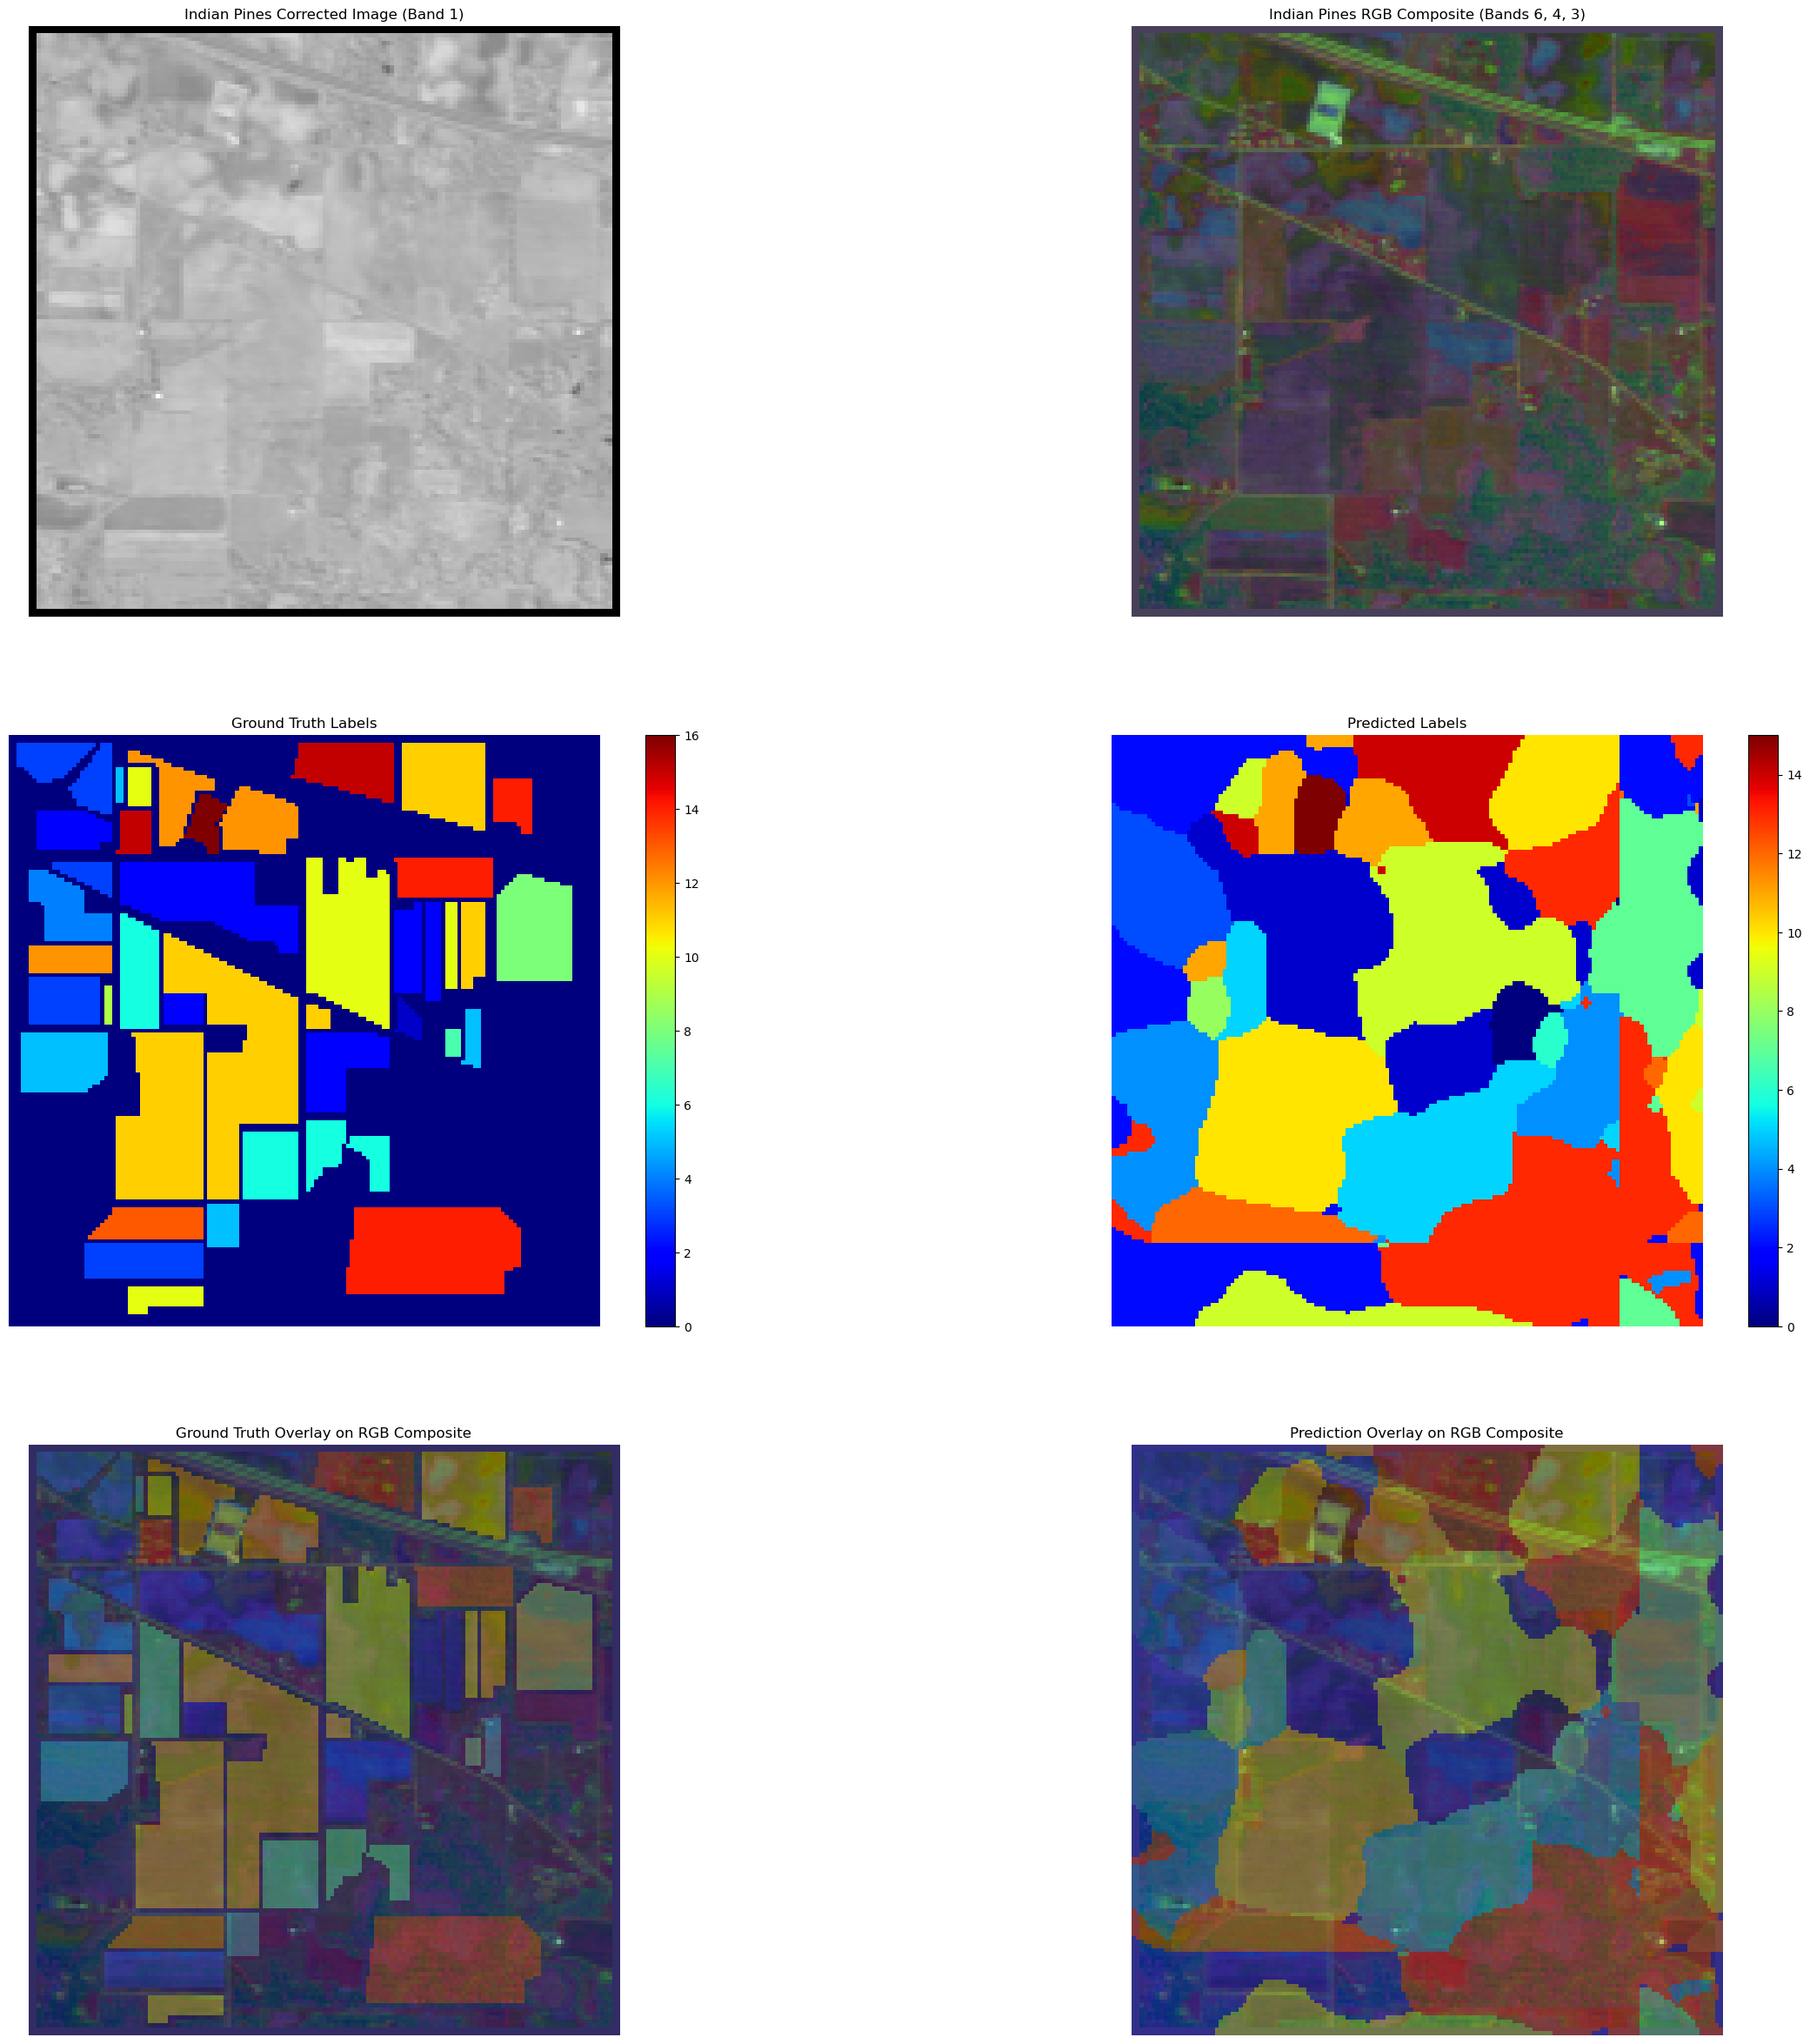

In [112]:
# Create a new figure with an additional row for the overlay images
fig, axes = plt.subplots(3, 2, figsize=(30, 30))  # Adjusted the subplot grid dimensions

# Plot the Indian Pines corrected image (grayscale)
axes[0, 0].imshow(data_processed[:, :, 0], cmap='gray')  # Assuming the first band represents grayscale
axes[0, 0].set_title('Indian Pines Corrected Image (Band 1)')
axes[0, 0].axis('off')

# Create an RGB composite
# Using the specified bands for RGB
red_band = 5  # Adjusting for zero-based indexing
green_band = 3
blue_band = 2

rgb_image = np.stack((data_processed[:, :, red_band], data_processed[:, :, green_band], data_processed[:, :, blue_band]), axis=-1)

# Normalize the RGB image for better visualization
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

# Plot the RGB composite
axes[0, 1].imshow(rgb_image)
axes[0, 1].set_title(f'Indian Pines RGB Composite (Bands {red_band + 1}, {green_band + 1}, {blue_band + 1})')
axes[0, 1].axis('off')

# Plot the ground truth labels
axes[1, 0].imshow(data_gt_unprocessed, cmap='jet')  # Using 'jet' colormap for better distinction between classes
axes[1, 0].set_title('Ground Truth Labels')
axes[1, 0].axis('off')
axes[1, 0].figure.colorbar(axes[1, 0].images[0], ax=axes[1, 0])

# Plot the predicted labels
pred_labels = torch.argmax(y_orgin, dim=1).cpu().numpy().reshape(height_orgin, width_orgin)
axes[1, 1].imshow(pred_labels, cmap='jet')  # Using 'jet' colormap for better distinction between classes
axes[1, 1].set_title('Predicted Labels')
axes[1, 1].axis('off')
axes[1, 1].figure.colorbar(axes[1, 1].images[0], ax=axes[1, 1])

# Overlay the ground truth on the RGB composite with opacity
overlay_gt = np.zeros_like(rgb_image)
for i in range(3):
    overlay_gt[:, :, i] = data_gt_unprocessed / class_num  # Normalize the ground truth labels for overlay

axes[2, 0].imshow(rgb_image)
axes[2, 0].imshow(data_gt_unprocessed, cmap='jet', alpha=0.3)  # Adjust the alpha value for desired opacity
axes[2, 0].set_title('Ground Truth Overlay on RGB Composite')
axes[2, 0].axis('off')

# Overlay the prediction on the RGB composite with opacity
overlay_pred = np.zeros_like(rgb_image)
for i in range(3):
    overlay_pred[:, :, i] = pred_labels / class_num  # Normalize the prediction labels for overlay

axes[2, 1].imshow(rgb_image)
axes[2, 1].imshow(pred_labels, cmap='jet', alpha=0.3)  # Adjust the alpha value for desired opacity
axes[2, 1].set_title('Prediction Overlay on RGB Composite')
axes[2, 1].axis('off')

plt.show()